In [15]:
import math
import numpy as np
import cv2, os
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [16]:
def pca(D, pca_num=20):
    L = np.dot(D, D.T)
    w, v = LA.eig(L)

    # 고유값 0인거 제거    
    zero_eigen = [i for i in range(len(w)) if abs(w[i]) <1e-4]
    j=0
    for i in zero_eigen:
        w = np.delete(w, i-j, axis=0)
        v = np.delete(v, i-j, axis=1)
        j+=1

    # 고유값 내림차순으로 정렬
    ww = np.sort(w.real)[::-1]
    index = np.argsort(w.real)[::-1]  
    vv = np.array([v[:,i].real for i in list(index)]).T 

    ww = ww[:pca_num]
    vv = vv[:, :pca_num]

    u = np.dot(vv.T, D)
    u = u/(LA.norm(u, axis=0))

    weight=np.dot(D,u.T)
    return u, weight

In [17]:
# 유클리디안 짝퉁. sqrt가 계산이오래걸린다니 제곱하는것만 넣었습니당.
# 별로여서 sqrt로! 다시바꿈

def ud(img, eigenvector, img_weight, index):
    test_weight = np.dot(img, eigenvector.T)
    weight = img_weight - test_weight.reshape(1,-1)
    dist = np.sum(weight*weight, axis=1)
    dist = np.sqrt(np.sum(weight*weight, axis=1))
    
    dist = pd.DataFrame(dist.reshape(1,-1), columns=index)
    return dist

In [18]:
def cosine_similarity(img, eigenvector, img_weight, index):
    test_weight = np.dot(img, eigenvector.T)
    dist = np.sqrt(np.sum(test_weight*test_weight))

    cosine_similiarity = np.zeros((1, img_weight.shape[0]))
    for i in range(img_weight.shape[0]):
        cosine_similiarity[0, i]=(np.sum(test_weight*img_weight[i]))/((dist)*(np.sqrt(np.sum(img_weight[i]*img_weight[i]))))
        
    cosine_similiarity = pd.DataFrame(cosine_similiarity.reshape(1,-1), columns=index)
    return cosine_similiarity

In [32]:
def ROC_dir(pca_num=20):
    data_loc = './big_augmentation/resample_even/'
    filelist = os.listdir(data_loc)

    length = len(filelist)
    imgary = np.zeros((length, 120*100))
    labels = []
    n=0
    for i in filelist:
        tmpimg = cv2.imread(data_loc+i, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))
        imgary[n] = tmpimg
        labels.append(i[0:2])
        n+=1
    
    eigenvector, img_weights = pca(imgary,pca_num)
    
    test_labels = os.listdir('./big_augmentation/resample_odd/')
    
    cols = labels.copy()
    cols.append("label")
    df= pd.DataFrame(columns = cols)
    
    n=0
    for imgs in test_labels:
        tmpimg = cv2.imread('./big_augmentation/resample_odd/'+imgs, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))

        df1 = ud(tmpimg, eigenvector, img_weights, labels)
        df1["label"]=imgs[0:2]
        df= pd.concat([df, df1])
        n+=1

    return df

In [33]:
def ROC_dir_cosine(pca_num=20):
    data_loc = './big_augmentation/resample_even/'
    filelist = os.listdir(data_loc)

    length = len(filelist)
    imgary = np.zeros((length, 120*100))
    labels = []
    n=0
    for i in filelist:
        tmpimg = cv2.imread(data_loc+i, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))
        imgary[n] = tmpimg
        labels.append(i[0:2])
        n+=1
    
    eigenvector, img_weights = pca(imgary,pca_num)
    
    test_labels = os.listdir('./big_augmentation/resample_odd/')
    
    cols = labels.copy()
    cols.append("label")
    df= pd.DataFrame(columns = cols)
    
    n=0
    for imgs in test_labels:
        tmpimg = cv2.imread('./big_augmentation/resample_odd/'+imgs, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))

        df1 = cosine_similarity(tmpimg, eigenvector, img_weights, labels)
        df1["label"]=imgs[0:2]
        df= pd.concat([df, df1])
        n+=1

    return df

In [21]:
def plot(pca_num=20):
    df = ROC_dir_cosine(pca_num)
    card = np.unique(df["label"])
    num_card = len(card)
    
    ntrain=int((df.shape[1]-1)/(len(np.unique(df.columns))-1)) # train 갯수
    ntest=int((df.shape[0])/num_card) # test set 갯수
    
    nn = ntrain * ntest
    
    authentic = np.zeros((num_card*nn,))
    imposter = np.zeros((num_card*nn*(num_card-1),))
    

    j=0
    fig = plt.figure(figsize=(10,30))
    #a = np.ceil(num_card/26)
    for i in range(num_card):
        name = card[i]

        for naname in card:
            T_T = np.array(df[df["label"]==name].loc[:, naname:naname]).reshape(-1,)
            if naname == name:
                temp=i*nn
                authentic[temp:temp+nn] = T_T
            else:
                temp = j*nn
                imposter[temp:temp+nn] = T_T
                j+=1 
        
        """ax = fig.add_subplot(26,a, i+1)
        ax.set_title(name)
        plt.hist(authentic[i*nn:(i+1)*nn], color = 'r',  bins=10, alpha = 0.6)
        plt.hist(imposter[i*nn*(num_card-1):(i+1)*nn*(num_card-1)], color = 'b',  bins=10, alpha = 0.6 )
        plt.tight_layout()"""
        
    plt.figure(figsize=(7,5))
    #plt.ylim((0, 4000))
    plt.hist(authentic, color = 'r',  bins=500, alpha = 0.6, label = "authentic")
    plt.hist(imposter, color = 'b',  bins=500, alpha = 0.6, label = "imposter")
    
    #plt.axvline(x=authentic.mean(), color = 'r')
    #plt.axvline(x=imposter.mean(), color = 'b')
    plt.legend()
        
    return  authentic, imposter # authentic.mean(), authentic.std(), imposter.mean(), imposter.std()

In [22]:
def FAR_FRR_cosine (authentic, imposter):
    threshold_array = np.arange(-1,1,0.0001)
    FAR_FRR_len = np.zeros((len(threshold_array),3))
    
    i=0
    auth_len = len(authentic)
    impo_len = len(imposter)
    for threshold in threshold_array:
        FAR_FRR_len[i][0]=threshold
        FAR_FRR_len[i][1]=len(authentic[authentic<threshold])/auth_len
        FAR_FRR_len[i][2]=len(imposter[imposter>threshold])/impo_len
        i+=1
    index = np.argmin(np.abs(FAR_FRR_len[:,1]-FAR_FRR_len[:,2]))
    threshold_EER = FAR_FRR_len[index][0]
    EER = np.mean(FAR_FRR_len[index][1:3])
    
    return threshold_EER,  EER, FAR_FRR_len

In [23]:
def FAR_FRR_ud (authentic, imposter):
    threshold_array = np.arange(0,100000,1000)
    FAR_FRR_len = np.zeros((len(threshold_array),3))
    
    i=0
    auth_len = len(authentic)
    impo_len = len(imposter)
    for threshold in threshold_array:
        FAR_FRR_len[i][0]=threshold
        FAR_FRR_len[i][1]=len(authentic[authentic>threshold])/auth_len
        FAR_FRR_len[i][2]=len(imposter[imposter<threshold])/impo_len
        i+=1
    index = np.argmin(np.abs(FAR_FRR_len[:,1]-FAR_FRR_len[:,2]))
    threshold_EER = FAR_FRR_len[index][0]
    EER = np.mean(FAR_FRR_len[index][1:3])
    
    return threshold_EER,  EER, FAR_FRR_len

In [48]:
cardlist=[]
for i in os.listdir('../dataset/'+'card_deck1'):
    cardlist.append(i[:-4])
print(np.array(cardlist))

['C10' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'CA' 'CJ' 'CK' 'CQ' 'D10'
 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'DA' 'DJ' 'DK' 'DQ' 'H10' 'H2'
 'H3' 'H4' 'H5' 'H6' 'H7' 'H8' 'H9' 'HA' 'HJ' 'HK' 'HQ' 'S10' 'S2' 'S3'
 'S4' 'S5' 'S6' 'S7' 'S8' 'S9' 'SA' 'SJ' 'SK' 'SQ']


In [47]:
def plot_ud(pca_num=20):
    df = ROC_dir(pca_num)
    card = np.unique(df["label"])
    num_card = len(card)
    
    ntrain=int((df.shape[1]-1)/(len(np.unique(df.columns))-1)) # train 갯수
    ntest=int((df.shape[0])/num_card) # test set 갯수
    
    nn = ntrain * ntest
    
    authentic = np.zeros((num_card*nn,))
    imposter = np.zeros((num_card*nn*(num_card-1),))
    

    j=0
    fig = plt.figure(figsize=(10,30))
    #a = np.ceil(num_card/26)
    for i in range(num_card):
        name = card[i]

        for naname in card:
            T_T = np.array(df[df["label"]==name].loc[:, naname:naname]).reshape(-1,)
            if naname == name:
                temp=i*nn
                authentic[temp:temp+nn] = T_T
            else:
                temp = j*nn
                imposter[temp:temp+nn] = T_T
                j+=1 
                
        
        """ax = fig.add_subplot(26,a, i+1)
        ax.set_title(name)
        plt.hist(authentic[i*nn:(i+1)*nn], color = 'r',  bins=10, alpha = 0.6)
        plt.hist(imposter[i*nn*(num_card-1):(i+1)*nn*(num_card-1)], color = 'b',  bins=10, alpha = 0.6 )
        plt.tight_layout()"""
        
    plt.figure(figsize=(7,5)
    #plt.ylim((0, 4000))
    plt.hist(authentic, color = 'r',  bins=500, alpha = 0.6, label = "authentic")
    plt.hist(imposter, color = 'b',  bins=500, alpha = 0.6, label = "imposter")
    
    #plt.axvline(x=authentic.mean(), color = 'r')
    #plt.axvline(x=imposter.mean(), color = 'b')
    plt.legend()
        
    return  authentic, imposter # authentic.mean(), authentic.std(), imposter.mean(), imposter.std()

SyntaxError: invalid syntax (<ipython-input-47-34ffe98801c6>, line 39)

<Figure size 720x2160 with 0 Axes>

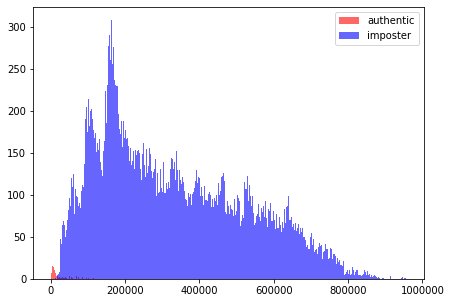

In [40]:
authentic, imposter = plot_ud(50)

In [46]:
authentic.shape

(832,)

In [41]:
threshold_EER,EER,FAR_FRR_len = FAR_FRR_ud(authentic, imposter)

<function matplotlib.pyplot.show(*args, **kw)>

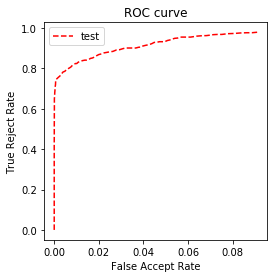

In [42]:
a=1.5
b="--"
plt.figure(figsize=(4,4))
plt.plot(FAR_FRR_len[:,2], 1-FAR_FRR_len[:,1], color="red", label="test", lw=a, ls=b)
plt.legend()
plt.xlabel('False Accept Rate')
plt.ylabel('True Reject Rate')
plt.title('ROC curve')
plt.show

In [44]:
threshold_EER

77000.0

In [43]:
EER

0.053532711161387636

In [167]:
FAR_FRR_len[FAR_FRR_len[:,0]==threshold_EER]

array([[7.70000000e+04, 5.40865385e-02, 5.29788839e-02]])

<Figure size 720x2160 with 0 Axes>

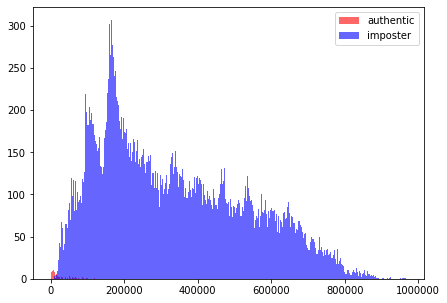

In [199]:
authentic, imposter = plot_ud(15)

In [200]:
threshold_EER,EER,FAR_FRR_len = FAR_FRR_ud(authentic, imposter)

In [201]:
threshold_EER

77000.0

In [31]:
data_loc = './big_augmentation/resample_even/'
filelist = os.listdir(data_loc)

length = len(filelist)
imgary = np.zeros((length, 120*100))
labels = []
n=0
for i in filelist:
    tmpimg = cv2.imread(data_loc+i, cv2.IMREAD_GRAYSCALE)
    print(tmpimg)
    tmpimg = np.reshape(tmpimg, (-1,))
    imgary[n] = tmpimg
    labels.append(i[0:2])
    n+=1

[[ 29 237 177 ...  85 122 104]
 [ 23 165 199 ... 205 202 180]
 [ 12 155 255 ... 245 213 159]
 ...
 [110 212 246 ... 240 190  44]
 [114 198 231 ... 230 189  45]
 [151 216 161 ... 194 202  71]]
[[  1  39  40 ...  44  43  60]
 [ 13 158 193 ... 179 174 213]
 [  0 109 192 ... 237 224 190]
 ...
 [ 62 193 254 ...   6   0   6]
 [ 54 193 244 ...   2   0   0]
 [ 70 201 206 ...   0   1   0]]
[[  1   7  10 ...   2   0   4]
 [  1 201 173 ... 102 111 149]
 [ 10 169 187 ... 205 201 208]
 ...
 [  6 128 220 ... 229 236 171]
 [  9 158 208 ... 241 211 170]
 [  0 212 188 ... 188 202 213]]
[[  0  55  20 ...  42  48  68]
 [  2 234 195 ... 184 199 196]
 [  6 151 207 ... 249 197 189]
 ...
 [ 79 199 237 ... 252 239 192]
 [101 201 214 ... 220 209 192]
 [ 83 164 147 ... 126 125 143]]
[[  0  14  15 ...   0  22   0]
 [ 75 149 130 ... 130 159  97]
 [ 83 188 211 ... 219 206  99]
 ...
 [  6  51 191 ... 255 247 198]
 [  3  61 190 ... 246 229 176]
 [ 23  94 188 ... 154 186 199]]
[[  1  30  23 ...  36  24  44]
 [102 191

 [ 28 237 190 ... 191 191 203]]
[[139 168 132 ... 120 129 165]
 [134 196 203 ... 230 202 198]
 [100 193 174 ... 253 236 186]
 ...
 [120 223 240 ... 141 160 154]
 [135 211 233 ... 222 210 188]
 [158 195 197 ... 190 189 205]]
[[  0  31  20 ...   0   0   0]
 [ 15 135 146 ...   0   0   0]
 [  2 165 203 ...   0   0   0]
 ...
 [ 11  80 203 ... 180 167 146]
 [  7  98 190 ... 228 210 196]
 [  0 141 169 ... 185 194 209]]
[[  0  45  31 ...  49  76  50]
 [ 83 201 184 ... 177 197 133]
 [ 41 181 221 ... 232 208 104]
 ...
 [ 32 181 226 ... 185 213 114]
 [ 35 198 212 ... 232 208 100]
 [ 42 163 123 ... 193 201 137]]
[[  0   4  16 ...   0   3  16]
 [  0 111 175 ... 127 120 152]
 [  0  97 192 ... 217 209 202]
 ...
 [  4  73 200 ... 157 238 192]
 [  5  97 202 ... 244 228 166]
 [  0 120 191 ... 173 191 216]]
[[  2  43  33 ...   0   7   1]
 [ 18 229 180 ... 123 133 123]
 [  2 156 197 ... 214 197 150]
 ...
 [ 23 152 228 ... 226 225 106]
 [ 11 167 208 ... 227 194 135]
 [  6 191 179 ... 154 196 166]]
[[  0   

 [  8 210 210 ... 175 195 203]]
[[  0 182 210 ...   0   2  11]
 [  4 135 197 ... 138 164 200]
 [  2 119 221 ... 247 201 190]
 ...
 [ 41 180 227 ... 211 227 197]
 [ 50 191 203 ... 222 216 189]
 [ 42 156 118 ... 144 158 183]]
[[  2  35  17 ...  65  66  53]
 [  5 161 127 ... 190 186 183]
 [  2 177 207 ... 243 206 161]
 ...
 [  5  67 198 ... 251 236 178]
 [  6  84 188 ... 203 206 194]
 [  4 112 184 ...  74  84 105]]
[[  0  74  83 ...  15  13  27]
 [ 14 130 184 ... 100 120 128]
 [ 11 107 197 ... 202 210 176]
 ...
 [  0 144 234 ... 250 216 121]
 [  1 148 190 ... 238 186 146]
 [  2 202 197 ... 164 177 194]]
[[  1   6   5 ...  18  45  30]
 [ 66 204 140 ... 179 213 143]
 [ 33 182 205 ... 240 195 110]
 ...
 [  0 133 224 ... 249 227 155]
 [  3 144 196 ... 220 201 204]
 [ 10 209 198 ... 119 133 164]]
[[ 18   9   0 ...  22  19  29]
 [ 18 230 203 ... 177 202 238]
 [  5 181 202 ... 228 208 175]
 ...
 [116 220 247 ... 253 241 184]
 [124 194 234 ... 230 208 194]
 [180 192 159 ... 151 149 192]]
[[ 80 19

 [  1 222 165 ... 194 207 164]]
[[  0  74  85 ...  16  25  67]
 [ 18 144 192 ... 178 177 205]
 [ 13 122 186 ... 241 218 187]
 ...
 [  0   9  22 ... 142 183 103]
 [  2   0   0 ... 190 207 107]
 [  1   0   3 ... 204 192 146]]
[[ 52 103  92 ...  48  47  68]
 [113 203 197 ... 184 187 222]
 [ 88 191 203 ... 240 236 179]
 ...
 [  7  97 210 ... 196 198 178]
 [  8 113 202 ... 198 205 193]
 [  0 142 193 ... 105 124 128]]
[[ 31  66  52 ...  44  36  49]
 [ 99 187 190 ... 176 179 192]
 [ 78 187 225 ... 238 228 203]
 ...
 [ 16 115 212 ... 236 226 143]
 [  9 131 200 ... 197 195 191]
 [  0 161 195 ... 108 124 152]]
[[  0  21  15 ...  44  39  84]
 [ 22 153 168 ... 195 194 201]
 [ 18 138 200 ... 237 221 163]
 ...
 [ 31 152 232 ...  19   1   0]
 [ 14 191 202 ...  18   0   4]
 [ 23 176 141 ...   0   1   0]]
[[  2  17  20 ...   0  11  19]
 [  0 111  96 ... 135 131 171]
 [  3 199 200 ... 223 215 201]
 ...
 [ 33 182 253 ... 238 203 111]
 [ 38 183 227 ... 238 199 135]
 [ 71 199 187 ... 175 205 169]]
[[ 47 10

In [29]:
tmpimg

array([None], dtype=object)

In [28]:
tmpimg

array([None], dtype=object)

In [50]:
pca_num=20
df = ROC_dir(pca_num)
card = np.unique(df["label"])
num_card = len(card)

ntrain=int((df.shape[1]-1)/(len(np.unique(df.columns))-1)) # train 갯수
ntest=int((df.shape[0])/num_card) # test set 갯수

nn = ntrain * ntest

authentic = np.zeros((num_card*nn,))
imposter = np.zeros((num_card*nn*(num_card-1),))


j=0
fig = plt.figure(figsize=(10,30))
#a = np.ceil(num_card/26)
for i in range(num_card):
    name = card[i]

    for naname in card:
        T_T = np.array(df[df["label"]==name].loc[:, naname:naname]).reshape(-1,)
        if naname == name:
            temp=i*nn
            authentic[temp:temp+nn] = T_T
        else:
            temp = j*nn
            imposter[temp:temp+nn] = T_T
            j+=1 

<Figure size 720x2160 with 0 Axes>

In [ ]:
## min값가지고만 비교

In [123]:
label_df = df.iloc[:,208].copy()

In [125]:
label_df[(df.iloc[:,:208].min(axis=1)>77000)]="NotDefined"

In [126]:
label_df[label_df=="NotDefined"]

Series([], Name: label, dtype: object)

In [96]:
num_df = df.iloc[:, :208]

In [128]:
comparision = (num_df.idxmin(axis=1) == label_df)

In [130]:
pd.concat([label_df[comparision==False], num_df.idxmin(axis=1)[comparision==False]], axis=1)

,label,0
0,C2,S2
0,C3,S3
0,C6,S7
0,C7,H1
0,D8,H6
0,D9,D1
0,DK,SJ
0,H5,S5
0,H9,H1
0,HQ,DQ


In [ ]:
## 자기자신 label인 카드들과 다 비교

In [131]:
label_df = df.iloc[:,208].copy()
num_df = df.iloc[:, :208]

In [145]:
label_df.iloc[0]

'C1'

In [147]:
df

,C1,C1,C1,C1,C2,C2,C2,C2,C3,C3,...,SJ,SK,SK,SK,SK,SQ,SQ,SQ,SQ,label
0,30689.847019,10207.351751,6644.286402,18481.022394,745343.212424,760522.087757,748151.587900,661155.216089,683676.638994,680871.845542,...,200477.032813,204252.953854,220580.117507,209831.060495,208140.283111,201577.222603,191283.979764,189551.542988,169908.705320,C1
0,17012.226055,19852.323747,7342.617210,5318.187246,733574.648027,748710.390928,736359.833606,649572.450594,672129.873714,669326.064237,...,193607.727327,197221.856714,212329.996037,202430.774276,200853.945197,194485.801676,185439.567034,183848.759074,167786.215569,C1
0,31388.742966,9461.181602,7452.586652,19150.761046,746193.229431,761372.880342,749001.552472,661999.871003,684503.644271,681698.708997,...,201021.321033,204807.194809,221200.718516,210405.934344,208707.577323,202138.536012,191781.531600,190043.059349,170177.453240,C1
0,44681.052026,14730.684199,24422.120957,34400.267533,757039.466928,772267.633715,759836.869744,672355.971842,694671.876042,691831.297651,...,202719.743981,207257.001003,224972.371955,213425.541494,211550.874145,203867.149575,192173.017964,190313.318764,165956.842324,C1
0,746580.197405,780090.848986,767113.779256,756789.232638,29805.173891,13846.300834,26448.430910,119038.754990,113503.374352,116343.936718,...,658497.494800,650415.733150,625336.965638,641490.675607,644454.481024,651998.555697,671663.244451,673836.493273,728177.410939,C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,192176.424597,213165.902075,204693.557165,197708.902725,615927.892253,630851.694375,618637.002268,532645.736021,545136.827948,542269.073013,...,25380.241697,7683.425390,21561.826791,2826.770850,2172.743081,30834.238335,43888.550152,45897.212032,96601.866174,SK
0,172299.961356,185944.405759,180215.251250,175584.924286,661443.666089,676605.577137,664191.382107,576603.526451,590603.424368,587693.538243,...,46304.871576,52954.237643,78070.347900,61330.791615,58673.116022,40896.062835,18451.753660,16096.037683,40351.640794,SQ
0,178834.744905,195444.748658,188665.392477,183117.104494,643388.111928,658505.933236,646126.453128,558842.296166,572647.510345,569748.553234,...,33060.341559,38625.647124,61316.712592,45738.296721,43442.162439,22924.753822,1741.961091,3713.384098,59253.051421,SQ
0,180429.326064,197811.440589,190783.512637,184984.818800,639053.578728,654146.381116,641784.733770,554660.120215,568394.009997,565499.990162,...,30082.165734,35493.070960,56920.017315,42012.011647,39863.504264,17851.615692,5613.892215,8223.129588,64222.506799,SQ


In [175]:
count=0
for i in range(len(label_df)):
    temp = num_df.iloc[i][num_df.columns==label_df.iloc[i]]
    for j in range(len(temp)):
        if temp.iloc[j]>77000:
            count+=1
            print("label : %s"%temp.index[j])
    print(count)

0
0
0
0
label : C2
1
label : C2
2
label : C2
3
label : C2
label : C2
label : C2
6
6
6
6
6
6
6
6
6
6
6
6
label : C5
label : C5
label : C5
9
9
9
label : C6
label : C6
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
label : CJ
label : CJ
label : CJ
14
14
label : CK
15
label : CK
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
label : DK
17
label : DK
label : DK
label : DK
20
20
20
label : DQ
21
label : DQ
22
label : DQ
23
label : DQ
24
24
24
24
24
24
24
24
24
24
24
24
24
label : H4
25
label : H4
26
26
label : H4
27
27
27
label : H5
label : H5
label : H5
label : H5
31
31
31
label : H6
32
32
label : H6
33
33
33
33
33
33
33
33
33
label : H9
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
label : HQ
label : HQ
label : HQ
label : HQ
38
label : HQ
label : HQ
label : HQ
label : HQ
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
label : 

In [174]:
count

46

In [177]:
count=0
for i in range(len(label_df)):
    temp = num_df.iloc[i][num_df.columns!=label_df.iloc[i]]
    for j in range(len(temp)):
        if temp.iloc[j]<77000:
            count+=1
            print("label : %s"%temp.index[j])
    print(count)

label : S1
1
label : S1
2
label : S1
3
label : S1
4
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
19
label : D3
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
label : S3
label : S3
label : S3
34
label : D3
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
label : S3
label : S3
label : S3
48
label : C3
label : C3
label : C3
label : C3
label : S2
label : S3
label : S3
label : S3
label : S3
57
label : C2
58
label : C2
label : S3
label : S3
label : S3
label : S3
63
label : C2
label : S2
label : S3
label : S3
label : S3
label : S3
69
label : C2
label : C2
label : C2
label : D3
label : H3
label : H3
label : H3
label : S2
label : S3
label : S3
label : S3
label : S3
81
label : H4
label : S4
label : S4
label : S4
label : S4
label : S5
label : S5


label : SK
label : SK
label : SQ
label : SQ
label : SQ
853
label : CK
label : CK
label : CK
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SK
label : SK
label : SK
label : SK
865
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
label : DJ
label : DJ
label : DJ
label : DJ
label : DQ
label : DQ
label : DQ
label : HJ
label : HJ
label : HJ
label : HK
label : HQ
label : HQ
label : HQ
label : HQ
label : SJ
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SQ
label : SQ
label : SQ
label : SQ
896
label : CK
label : CK
label : CK
label : DJ
label : DJ
label : DJ
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SK
label : SQ
915
label : CK
label : CK
label : CK
label : DJ
label : DJ
label : DJ
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SJ
label : SK
label : SK
label : SK
label : SK
label : SQ
932
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
l

1609
label : C9
label : C9
label : C9
label : C9
1613
label : C9
label : C9
label : C9
label : C9
1617
label : C2
label : C2
label : C2
label : D2
label : D2
label : D2
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
1634
label : C2
label : C2
label : C2
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
1648
label : C2
label : C2
label : C2
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
1662
label : C2
label : C2
label : C2
label : D3
label : D3
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S3
label : S3
label : S3
label : S3
1678
label : C2
label : C2
label : C2
label : C2
label : C3
label : C3
label : C3
label : C3
label : D3
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
1693
label : C2
label : C2
label : C2
lab

In [179]:
pca_num=50
df = ROC_dir(pca_num)
card = np.unique(df["label"])
num_card = len(card)

ntrain=int((df.shape[1]-1)/(len(np.unique(df.columns))-1)) # train 갯수
ntest=int((df.shape[0])/num_card) # test set 갯수

nn = ntrain * ntest

authentic = np.zeros((num_card*nn,))
imposter = np.zeros((num_card*nn*(num_card-1),))


j=0
fig = plt.figure(figsize=(10,30))
#a = np.ceil(num_card/26)
for i in range(num_card):
    name = card[i]

    for naname in card:
        T_T = np.array(df[df["label"]==name].loc[:, naname:naname]).reshape(-1,)
        if naname == name:
            temp=i*nn
            authentic[temp:temp+nn] = T_T
        else:
            temp = j*nn
            imposter[temp:temp+nn] = T_T
            j+=1 

<Figure size 720x2160 with 0 Axes>

In [181]:
label_df = df.iloc[:,208].copy()
label_df[(df.iloc[:,:208].min(axis=1)>77000)]="NotDefined"

In [182]:
label_df[label_df=="NotDefined"]

Series([], Name: label, dtype: object)

In [183]:
num_df = df.iloc[:, :208]

In [184]:
comparision = (num_df.idxmin(axis=1) == label_df)

In [185]:
pd.concat([label_df[comparision==False], num_df.idxmin(axis=1)[comparision==False]], axis=1)

,label,0
0,C2,S2
0,C6,S7
0,C7,H1
0,D9,D1
0,DK,SJ
0,H5,S5
0,H9,H1
0,HQ,DQ
0,HQ,DQ
0,S2,C2


In [186]:
label_df = df.iloc[:,208].copy()
num_df = df.iloc[:, :208]

In [187]:
count=0
for i in range(len(label_df)):
    temp = num_df.iloc[i][num_df.columns==label_df.iloc[i]]
    for j in range(len(temp)):
        if temp.iloc[j]>77000:
            count+=1
            print("label : %s"%temp.index[j])
    print(count)

0
0
0
0
label : C2
1
label : C2
2
label : C2
3
label : C2
label : C2
label : C2
6
6
6
6
6
6
6
6
6
6
6
6
label : C5
label : C5
label : C5
9
9
9
label : C6
label : C6
11
11
11
11
label : C7
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
label : CJ
label : CJ
label : CJ
15
15
label : CK
16
label : CK
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
label : DK
18
label : DK
label : DK
label : DK
21
21
21
label : DQ
22
label : DQ
23
label : DQ
24
label : DQ
25
25
25
25
25
25
25
25
25
25
25
25
25
label : H4
26
label : H4
27
27
27
27
27
label : H5
label : H5
label : H5
label : H5
31
31
31
label : H6
32
32
label : H6
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
33
label : HQ
label : HQ
label : HQ
label : HQ
37
label : HQ
label : HQ
label : HQ
label : HQ
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
label : S8
42
label

In [188]:
count=0
for i in range(len(label_df)):
    temp = num_df.iloc[i][num_df.columns!=label_df.iloc[i]]
    for j in range(len(temp)):
        if temp.iloc[j]<77000:
            count+=1
            print("label : %s"%temp.index[j])
    print(count)

label : S1
1
label : S1
2
label : S1
3
label : S1
4
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
20
label : D3
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
label : S3
label : S3
label : S3
36
label : D3
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
label : S3
label : S3
label : S3
51
label : C3
label : C3
label : C3
label : C3
label : S2
label : S3
label : S3
label : S3
label : S3
60
label : C2
61
label : C2
label : S3
label : S3
label : S3
label : S3
66
label : C2
label : S2
label : S3
label : S3
label : S3
label : S3
72
label : C2
label : C2
label : D3
label : H3
label : H3
label : S2
label : S3
label : S3
label : S3
label : S3
82
label : H4
label : S4
label : S4
label : S4
label : S4
label : S5


label : HK
label : HK
label : HK
label : HK
label : HQ
label : HQ
label : HQ
label : HQ
label : SJ
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SK
label : SQ
label : SQ
label : SQ
818
label : CK
label : CK
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
label : DK
label : DK
label : DK
label : DK
label : DQ
label : DQ
label : DQ
label : HK
label : HK
label : HK
label : HK
label : HQ
label : HQ
label : HQ
label : HQ
label : SJ
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SK
label : SQ
label : SQ
label : SQ
851
label : CK
label : CK
label : CK
label : DJ
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SK
label : SK
label : SK
label : SK
864
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
label : DJ
label : DJ
label : DJ
label : DJ
label : DQ
label : DQ
label : DQ
label : HJ
label : HJ
label : HJ
label : HK
label : HQ
label : HQ
label : HQ
label : HQ
label : SJ
label : SJ
label : SJ
label : SJ
label : S

label : SQ
label : SQ
label : SQ
label : SQ
1577
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
label : DJ
label : DJ
label : DJ
label : DJ
label : DK
label : DQ
label : DQ
label : DQ
label : HJ
label : HJ
label : HJ
label : SJ
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SQ
label : SQ
label : SQ
label : SQ
1604
label : C9
label : C9
label : C9
label : C9
1608
label : C9
label : C9
label : C9
label : C9
1612
label : C9
label : C9
label : C9
label : C9
1616
label : C9
label : C9
label : C9
label : C9
1620
label : C2
label : C2
label : C2
label : D2
label : D2
label : D2
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
1637
label : C2
label : C2
label : C2
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
1651
label : C2
label : C2
label : C2
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
lab

In [198]:
pca_num=15
df = ROC_dir(pca_num)

In [202]:
label_df = df.iloc[:,208].copy()
num_df = df.iloc[:, :208]

In [203]:
count=0
for i in range(len(label_df)):
    temp = num_df.iloc[i][num_df.columns==label_df.iloc[i]]
    for j in range(len(temp)):
        if temp.iloc[j]>77000:
            count+=1
            print("label : %s"%temp.index[j])
    print(count)

0
0
0
0
label : C2
1
label : C2
2
label : C2
3
label : C2
label : C2
label : C2
6
6
6
6
6
6
6
6
6
6
6
6
label : C5
label : C5
label : C5
9
9
9
label : C6
label : C6
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
label : CJ
label : CJ
label : CJ
14
14
label : CK
15
label : CK
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
label : DK
17
label : DK
label : DK
label : DK
20
20
20
label : DQ
21
label : DQ
22
label : DQ
23
label : DQ
24
24
24
24
24
24
24
24
24
24
24
24
24
label : H4
25
label : H4
26
26
label : H4
27
27
27
label : H5
label : H5
label : H5
label : H5
31
31
31
label : H6
32
32
label : H6
33
33
33
33
33
33
33
33
33
label : H9
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
label : HQ
label : HQ
label : HQ
label : HQ
38
label : HQ
label : HQ
label : HQ
label : HQ
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
label : 

In [204]:
count=0
for i in range(len(label_df)):
    temp = num_df.iloc[i][num_df.columns!=label_df.iloc[i]]
    for j in range(len(temp)):
        if temp.iloc[j]<77000:
            count+=1
            print("label : %s"%temp.index[j])
    print(count)

label : S1
1
label : S1
2
label : S1
3
label : S1
4
label : D3
label : D3
label : D3
label : H2
label : H2
label : H2
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
19
label : D3
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
label : S3
label : S3
label : S3
33
label : D3
label : H2
label : H3
label : H3
label : H3
label : H3
label : S2
label : S2
label : S2
label : S2
label : S3
label : S3
label : S3
label : S3
47
label : C3
label : C3
label : C3
label : C3
label : S2
label : S3
label : S3
label : S3
label : S3
56
label : C2
57
label : C2
label : S3
label : S3
label : S3
label : S3
62
label : C2
label : S2
label : S3
label : S3
label : S3
label : S3
68
label : C2
label : C2
label : C2
label : D3
label : H3
label : H3
label : S2
label : S3
label : S3
label : S3
label : S3
79
label : H4
label : S4
label : S4
label : S4
label : S4
label : S5
label : S5
label : S5
label : S5


label : SK
label : SK
label : SQ
label : SQ
label : SQ
854
label : CK
label : CK
label : CK
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SK
label : SK
label : SK
label : SK
866
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
label : DJ
label : DJ
label : DJ
label : DJ
label : DQ
label : DQ
label : DQ
label : HJ
label : HJ
label : HJ
label : HK
label : HQ
label : HQ
label : HQ
label : HQ
label : SJ
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SQ
label : SQ
label : SQ
label : SQ
897
label : CK
label : CK
label : CK
label : DJ
label : DJ
label : DJ
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SJ
label : SJ
label : SJ
label : SK
label : SK
label : SK
label : SK
label : SQ
916
label : CK
label : CK
label : CK
label : DJ
label : DJ
label : DJ
label : DJ
label : HK
label : HK
label : HK
label : HK
label : SJ
label : SK
label : SK
label : SK
label : SK
label : SQ
933
label : CJ
label : CK
label : CQ
label : CQ
label : CQ
l

1815
label : C6
label : C6
label : C6
label : C6
label : S7
1820
label : C6
label : C6
label : C6
label : C6
label : S6
1825
label : C6
label : C6
label : C6
label : C6
label : S6
1830
label : C6
label : C6
label : C6
label : C6
label : S6
1835
label : C6
label : C6
label : C6
label : C6
label : S6
1840
label : C8
label : C8
label : C8
label : C8
1844
label : S7
1845
label : S7
1846
label : S7
1847
1847
1847
label : S1
1848
label : S1
1849
label : CA
label : CA
label : CA
label : CA
1853
label : CA
label : CA
label : CA
label : CA
1857
label : CA
label : CA
label : CA
label : CA
1861
label : CA
label : CA
label : CA
label : CA
1865
label : CK
label : CK
label : CK
label : CQ
label : CQ
label : CQ
label : CQ
label : DJ
label : DJ
label : DJ
label : DJ
label : DK
label : DK
label : DK
label : DK
label : DQ
label : DQ
label : DQ
label : HK
label : HK
label : HK
label : HK
label : HQ
label : HQ
label : HQ
label : HQ
label : SK
label : SK
label : SK
label : SK
label : SQ
label : SQ
label : 